In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [3]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

In [11]:
gsp["datetime_gmt"].values[(gsp["datetime_gmt"] >= np.datetime64("2020-01-01")) & (gsp["datetime_gmt"] < np.datetime64("2022-01-01"))]

array(['2020-01-01T00:00:00.000000000', '2020-01-01T00:30:00.000000000',
       '2020-01-01T01:00:00.000000000', ...,
       '2021-12-31T22:30:00.000000000', '2021-12-31T23:00:00.000000000',
       '2021-12-31T23:30:00.000000000'], dtype='datetime64[ns]')

In [3]:
evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [5]:
# stolen from datapipes

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )


def build_datasets_from_local(step: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(f"/home/tom/local_data/basic_processed_nwp_data_step_{step}.npy")
    X = pd.DataFrame(data=X.reshape(X.shape[1], X.shape[2]).T, columns=nwp.coords["variable"], index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    return X, y

In [144]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [146]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


In [147]:
import pickle

# with open('/home/tom/local_data/xgb_forecast_steps_v1_ts_split.pkl', 'wb') as f:
#     pickle.dump(results, f)

with open('/home/tom/local_data/xgb_forecast_steps_v1_ts_split.pkl', 'rb') as f:
    results = pickle.load(f)

### View the results of the model

With this model, we are modelling the PV output at multiple time-steps in the future using NWP forecasts. In particular, we model PV at $t + X$, using NWP forecasts of step $X$ at time $t$. Each time-step regression forecast models are independent (and they also have different covariates).

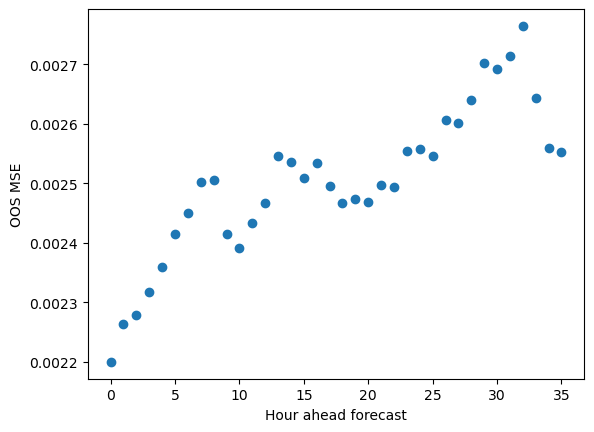

In [163]:
# plot the MAE of the OOS for each model
mae_test = pd.Series({step: r.mse_test_loss for step, r in results.items()})
plt.scatter(mae_test.index, mae_test.values)
plt.ylabel("OOS MSE")
plt.xlabel("Hour ahead forecast")
plt.show()

Comment:
Looks like there was significantly more data leakage than I thought there would be! Also makes sense why the longer horizon forecasts would be better - they're probably less noisy so the NN lookup is easier. Good to see rough decay in performance as time horizon increases. We will try and understand the cyclical nature of the errors next.

In [67]:
# rerun experiments but this time condition on the time point we are forecasting - so we can get an intution for model performance at different parts of the day.

@dataclass
class ExperimentSummarySplitBuckets:
    mse_train_loss_splits: dict
    mse_test_loss_splits: dict
    mae_train_loss_splits: dict
    mae_test_loss_splits: dict
    model: XGBRegressor


SPLIT_TIME_BUCKETS_HOURS = [0, 5, 11, 15, 21, 24]
SPLIT_TIME_BUCKETS_LABELS = ["night", "morning", "day", "evening", "night"]


def run_experiment_for_day_night_split(X: pd.DataFrame,
                   y: pd.DataFrame,
                   forecast_shift: np.datetime64,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG,
                   ) -> ExperimentSummarySplitBuckets:
    
    
    train_mse, train_mae, test_mse, test_mae = dict(), dict(), dict(), dict()

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    # when evaluating the model, condition on the time we are forecasting
    eval_timeseries_train = y_train.shift(freq=forecast_shift).index
    eval_timeseries_test = y_test.shift(freq=forecast_shift).index
    splits_train = pd.cut(eval_timeseries_train.hour, SPLIT_TIME_BUCKETS_HOURS, retbins=False, right=True, include_lowest=True, labels=SPLIT_TIME_BUCKETS_LABELS, ordered=False)
    splits_test = pd.cut(eval_timeseries_test.hour, SPLIT_TIME_BUCKETS_HOURS, retbins=False, right=True, include_lowest=True, labels=SPLIT_TIME_BUCKETS_LABELS, ordered=False)
    
    for split in SPLIT_TIME_BUCKETS_LABELS:
        _X_train, _y_train = X_train.loc[splits_train == split], y_train.loc[splits_train == split]
        _X_test, _y_test = X_test.loc[splits_test == split], y_test.loc[splits_test == split]
        y_pred_test, y_pred_train = model.predict(_X_test), model.predict(_X_train)    
        
        train_mae[split], test_mae[split] = mean_absolute_error(_y_train, y_pred_train), mean_absolute_error(_y_test, y_pred_test)
        train_mse[split], test_mse[split] = mean_squared_error(_y_train, y_pred_train), mean_squared_error(_y_test, y_pred_test)
    
    
    return ExperimentSummarySplitBuckets(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwo
    )

In [70]:
day_split_results = dict()

for step in range(36):
    X, y = build_datasets_from_local(step)
    shift = nwp.coords["step"].values[step]
    day_split_results[step] = run_experiment_for_day_night_split(X, y, shift)

Text(0.5, 0, 'Forecast Horizon')

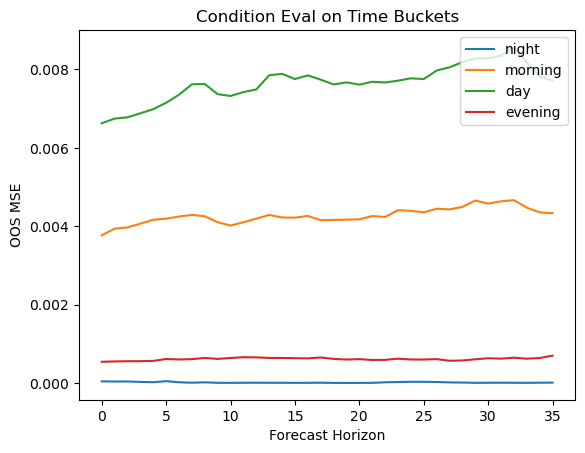

In [164]:
pd.DataFrame.from_dict({step: r.mse_test_loss_splits for step, r in day_split_results.items()}).T.plot()
plt.title("Condition Eval on Time Buckets")
plt.ylabel("OOS MSE")
plt.xlabel("Forecast Horizon")